<a href="https://colab.research.google.com/github/lmoghimi/personal-processing/blob/main/xrd_phase_analysis_Lauren.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run these first

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import heapq

# timestamps = ['primary-1', ]
shift = True            #
get_timestamps = True
ntimestamps = 2
#ntimestamps_depths
lw = 0.75 #linewidth
userdir = "/content/drive/Shareddrives/leoradm_group/NSLS-II_202403"
scriptdir = os.path.join(userdir, 'userScripts')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#@title Peak positions for reference + save settings
wavelength = 0.1824 #angstrom
'''
ref_tth_fe = [5.205, 9.022, 7.364, 10.421, 11.656, 12.772, 13.801, 14.759] #2theta
ref_d_fe = 0.5*wavelength/np.sin(np.radians(np.divide(ref_tth_fe,2))) #conversion to d
ref_q_fe = 2*np.pi/ref_d_fe #conversion to q
'''
#ref_q_fe = [3.128, 5.419, 4.424, 6.995, 8.277, 6.257, 7.663]
ref_q_fe = [3.128, 5.419, 4.424]
#lincol_fe='tab:green' #iron
lincol_fe='tab:brown'

'''
ref_tth_w = [4.833, 6.837, 4.185, 8.019, 10.820, 8.376, 11.856, 10.545] #remove 3rd number if plot in tth
ref_d_w = 0.5*wavelength/np.sin(np.radians(np.divide(ref_tth_w,2)))
ref_q_w = 2*np.pi/ref_d_w
'''
#ref_q_w = [2.905, 4.108, 2.516, 4.817, 6.495, 5.031, 7.115, 6.331, 8.715, 8.593, 7.547, 8.216, 5.810]
ref_q_w = [2.905, 4.108, 2.516]
#lincol_w='tab:red' #wustite
lincol_w='tab:pink'

'''
ref_tth_m = [4.145, 7.083, 6.520, 3.540, 9.639, 5.019, 6.143, 8.324, 10.846] #remove 1st one if plot in tth
ref_d_m = 0.5*wavelength/np.sin(np.radians(np.divide(ref_tth_m,2)))
ref_q_m = 2*np.pi/ref_d_m
'''
#ref_q_m = [2.4783, 2.5973, 4.2458, 3.8889, 2.1214, 2.9982, 5.7584, 3.6680, 1.2887, 4.9086]
ref_q_m = [2.4783, 2.5973, 4.2458]
#lincol_m='tab:purple' #magnetite
lincol_m='tab:green'

'''
ref_tth_h = [3.870, 4.150, 6.167, 5.675, 7.033, 7.190, 2.837, 7.973] #remove 2nd number if plot in tth
ref_d_h = 0.5*wavelength/np.sin(np.radians(np.divide(ref_tth_h,2)))
ref_q_h = 2*np.pi/ref_d_h
'''
#ref_q_h = [2.4985, 2.3135, 3.7118, 4.3288, 3.41365, 4.2259, 1.6965, 2.8481, 4.8017, 3.92775, 4.9868, 5.6860, 5.5009, 5.9533, 6.5394]
ref_q_h = [2.4985, 2.3135, 3.7118]
#lincol_h='tab:orange' #hematite
lincol_h='tab:cyan'

lincol_h_ore = 'tab:purple'

lincol_magh='tab:olive' #maghemite

lincol_qz = 'tab:gray' #quartz

#lincol_wf = 'tab:blue' #sets the line color for the waterfall series
#lincol_wf = 'navy'

#Would you like to save the plots? Enter y/n
response = "n" ##### at some point it would be nice to make this pop up as a prompt so that we don't forget to change the response
xrd_type = "q" ##### d or tth or q. also make this pop up as a prompt

Loading file /content/drive/Shareddrives/leoradm_group/NSLS-II_202403/tiff_base/run51_hematite_pellet_H2_blue_take3/integration/run51_hematite_pellet_H2_blue_take3_20240328-161448_1894cd_primary-1_mean_q.chi
Loading file /content/drive/Shareddrives/leoradm_group/NSLS-II_202403/tiff_base/run51_hematite_pellet_H2_blue_take3/integration/run51_hematite_pellet_H2_blue_take3_20240328-161448_1894cd_primary-124_mean_q.chi
Showing the plot without saving...


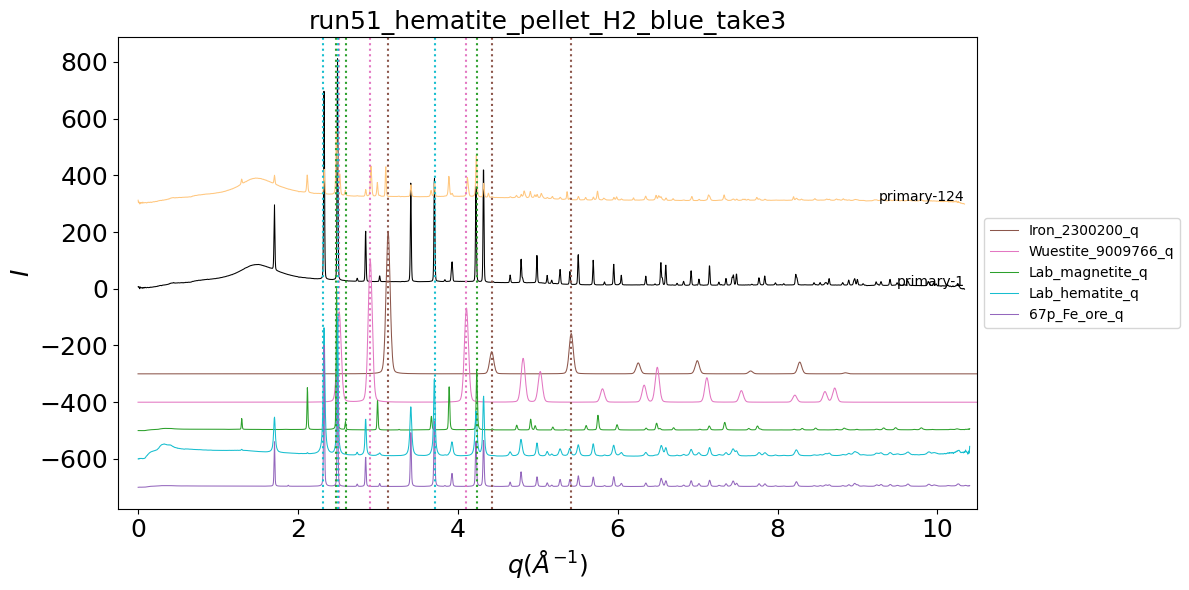

In [4]:
#@title Phase analysis for q
for run in ['run51']:

    ###################### parsing the filename
    tiffdir = os.path.join(userdir, 'tiff_base')
    # print(userdir, tiffdir)
    runslist = glob.glob(tiffdir + '/*')
    # print(runslist)
    runsdict = {}
    for run_item in runslist:
        run_number = os.path.basename(run_item).split('_')[0]
        runsdict[run_number] = run_item
    # print(runsdict)

    file_pattern = os.path.join(runsdict[run], 'integration', '*_mean_q.chi')
    expname = os.path.basename(runsdict[run])
    # print(file_pattern)
    filelist = glob.glob(file_pattern)
    # print(filelist)
    filedict = {}
    for filename in filelist:
        file_parse = os.path.basename(filename).split('_')
        if not ('ss' in file_parse or 'stg2' in file_parse):
            file_number = file_parse[-3] # this takes the primary number
            filedict[file_number] = filename

    ################# grab ntimestamps curves (equally spacing in time)
    if get_timestamps:
        timestamps = ['primary-%d'%k for k in np.linspace(1, len(filedict)-1, ntimestamps).astype(int)]

    ################# plotting setting
    figsize = (12, 6)
    fs = 18
    fig, ax = plt.subplots(figsize=figsize, tight_layout=True) #this is key for "hold on"!!!!

    num_of_lines = len(timestamps)
    lincol_gradient = iter(cm.copper(np.linspace(0,1,num_of_lines))) #Wistia, copper, and autumn are nice gradients
    counting = 0
    ################ plotting selected timestamps
    for iv, timestamp in enumerate(timestamps):
        filename = filedict[timestamp]
        print('Loading file', filename)
        rawdata = np.loadtxt(filename)
        q = rawdata[:, 0]
        I = rawdata[:, 1]
        I = I + iv * 300
        #I = I + iv * 100 #iv is basically the index number for the scan. this makes a waterfall plot
        # I = I/I.max() + 0.25 * iv
        #ax.plot(d, I, label=timestamp, color = lincol_wf, linewidth = lw)
        #ax.plot(d, I, color = lincol_wf, linewidth = lw)


        c=next(lincol_gradient)
        ax.plot(q, I, color = c, linewidth = lw)
        #ax.plot(tth, I, label=timestamp) #####
        #ax.text(d[-1], I[-1], timestamp, ha='right', va='bottom')
        ax.text(q[-1], I[-1], timestamp, ha='right', va='bottom')
        #ax.text(tth[-1], I[-1], timestamp, ha='left', va='bottom') #####

        counting = counting + 1

    ######### load multiple reference files, Yifan, 2024/4/12
    #ref_phases = ['SU_55Fe_S3_20231113-123848_ffaed2_primary-1_mean_q','SU_Lmag_S1_20231113-123625_d9ddff_primary-1_mean_q','SU_Lhem_S2_20231113-123737_848648_primary-1_mean_q','SU_67p1Fe_S6_20231113-124225_d3d593_primary-1_mean_q']
    #ref_phases = ['Iron_2300200', 'Wuestite_9009766','Magnetite_1528612','Hematite_1011240']
    ref_phases = ['Iron_2300200_q', 'Wuestite_9009766_q','Lab_magnetite_q','Lab_hematite_q','67p_Fe_ore_q']
    #ref_phases = ['Iron_2300200', 'Wuestite_9009766','Magnetite_1528612','Hematite_1011240','Maghemite_9006316']
    #color_ref_phases = [lincol_fe, lincol_m, lincol_h, lincol_h_ore] #setting the line colors for the reference files. these are predetermined in the previous code cell
    #color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h]
    color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h, lincol_h_ore]
    ref_shift_y = -100
    for i_phase, ref_phase in enumerate(ref_phases):
        reffile = os.path.join(userdir, 'userScripts', 'xrd_profiles', ref_phase + '.txt')
        refdata = np.loadtxt(reffile)
        q_ref = refdata[:, 0]
        I_ref = (refdata[:, 1] - refdata[0, 1]) #"grounding" the data
        sensitivity = 500 #the larger the value, the more prominent the peaks
        I_ref = I_ref/(I_ref.max()/sensitivity)  + ref_shift_y*(i_phase + 1) -200
        ax.plot(q_ref, I_ref, label= ref_phase, linewidth= lw, color= color_ref_phases[i_phase])
        #ax.plot(tth_ref, I_ref, label= ref_phase) #####
        #ax.plot(tth_ref, I_ref, label='Ref_' + ref_phase)
        #ax.text(tth_ref[-1], I_ref[-1], ref_phase, ha='left', va='bottom')

    xlim_left, xlim_right = -0.25, 10.5 #for q
    ax.set_xlim(xlim_left, xlim_right)
    ######## put the legend outside of the box, Yifan, 20240422 ############
    # ax.legend(loc='lower right')
    ax.legend(loc='center left', bbox_to_anchor=[1, 0.5])
    ########################################################################

    ax.set_xlabel(r'$q  ({\AA}^{-1})$', fontsize=fs)
    ax.set_ylabel(r'$I$', fontsize=fs)
    ax.set_title(expname, fontsize=fs)
    ax.tick_params(labelsize=fs)
    #ax.set_yticklabels([]) #turns off tick labels for vertical axis

################# plot vertical lines for the reference phase peaks
    for i_vert_line in ref_q_fe: #plot the vertical lines
        plt.axvline(x=i_vert_line, linestyle='dotted', color=lincol_fe)

    for i_vert_line in ref_q_w:
            plt.axvline(x=i_vert_line, linestyle='dotted', color=lincol_w)

    for i_vert_line in ref_q_m:
            plt.axvline(x=i_vert_line, linestyle='dotted', color=lincol_m)

    for i_vert_line in ref_q_h:
            plt.axvline(x=i_vert_line, linestyle='dotted', color=lincol_h)

 ########## save settings
    if response == "y":
      print("Saving the file...!")
      fname_typ = 'wf_'+ xrd_type + '_' + expname + '.png' #wf = waterfall
      save_loc = os.path.join(userdir, 'userAnalysis' + '/' + 'waterfallPlots'+ '/')
      if not os.path.isdir(save_loc):
          os.makedirs(save_loc)
      plt.savefig(save_loc + fname_typ)
    elif response == "n":
      print("Showing the plot without saving...")
      plt.show()
    else: print("Please enter yes or no.")